In [7]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [8]:
arima_path = Path("./") / "out" / "arima" 
arima_files = []
arima_scores = {}
arima_stock_prices = {}
for point in pd.date_range("2015-01-01", "2017-01-01"):
    point = point.strftime("%Y-%m-%d")
    arima_files.append(arima_path / f"{point}.csv")

    df = pd.read_csv(arima_files[-1], index_col=0)
    for score in df.columns:
        arima_scores[score] = arima_scores.get(score, []) + [df[score].mean()]

    for stock in df.index:
        arima_stock_prices[stock] = arima_stock_prices.get(stock, []) + [df.loc[stock]["mape"]]

for score in arima_scores:
    arima_scores[score] = sum(arima_scores[score]) / len(arima_scores[score])
    print(f"{score}: {arima_scores[score]:.4f}")

mse: 0.5400
rmse: 0.2934
mae: 0.2439
mape: 0.2486


In [9]:
es_path = Path("./") / "out" / "es" 
es_files = []
es_scores = {}
es_stock_prices = {}
for point in pd.date_range("2015-01-01", "2017-01-01"):
    point = point.strftime("%Y-%m-%d")
    es_files.append(es_path / f"{point}.csv")

    df = pd.read_csv(es_files[-1], index_col=0)
    for score in df.columns:
        es_scores[score] = es_scores.get(score, []) + [df[score].mean()]

    for stock in df.index:
        es_stock_prices[stock] = es_stock_prices.get(stock, []) + [df.loc[stock]["mape"]]

for score in es_scores:
    es_scores[score] = sum(es_scores[score]) / len(es_scores[score])
    print(f"{score}: {es_scores[score]:.4f}")

mse: 0.0357
rmse: 0.1518
mae: 0.1285
mape: 0.1253


In [10]:
uc_path = Path("./") / "out" / "uc" 
uc_files = []
uc_scores = {}
uc_stock_prices = {}
for point in pd.date_range("2015-01-01", "2017-01-01"):
    point = point.strftime("%Y-%m-%d")
    uc_files.append(uc_path / f"{point}.csv")

    df = pd.read_csv(uc_files[-1], index_col=0)
    for score in df.columns:
        uc_scores[score] = uc_scores.get(score, []) + [df[score].mean()]

    for stock in df.index:
        uc_stock_prices[stock] = uc_stock_prices.get(stock, []) + [df.loc[stock]["mape"]]

for score in uc_scores:
    uc_scores[score] = sum(uc_scores[score]) / len(uc_scores[score])
    print(f"{score}: {uc_scores[score]:.4f}")

mse: 0.0357
rmse: 0.1518
mae: 0.1285
mape: 0.1253


In [11]:
prophet_path = Path("./") / "out" / "prophet" / "test2"
prophet_files = []
prophet_scores = {}
prophet_stock_scores = {}
for point in pd.date_range("2015-01-01", "2017-01-01"):
    point = point.strftime("%Y-%m-%d")
    prophet_files.append(prophet_path / f"prophet_{point}_multiplicative_lt0_w.csv")

    df = pd.read_csv(prophet_files[-1], index_col=0)
    for score in df.columns:
        prophet_scores[score] = prophet_scores.get(score, []) + [df[score].mean()]

    for stock in df.index:
        prophet_stock_scores[stock] = prophet_stock_scores.get(stock, []) + [df.loc[stock]["mape"]]

for score in prophet_scores:
    prophet_scores[score] = sum(prophet_scores[score]) / len(prophet_scores[score])
    print(f"{score}: {prophet_scores[score]:.4f}")

mse: 0.1147
rmse: 0.2696
mae: 0.2335
mape: 0.2421


0.15 & 0.3 & 0.45 & 0.6 & 0.75 & 0.9 & 1.05 \\
\hline
11.28\% & 79.87\% & 95.58\% & 98.67\% & 99.34\% & 99.78\% & 100.00\% \\
\hline


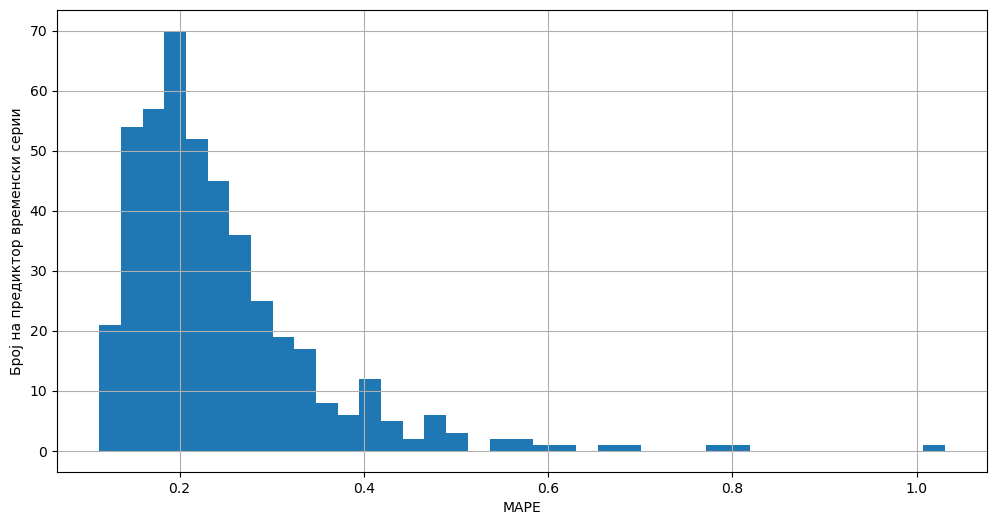

In [12]:
stocks = []
scores = []
for stock in prophet_stock_scores.keys():
    score = sum(prophet_stock_scores[stock]) / len(prophet_stock_scores[stock])
    stocks.append(stock)
    scores.append(score)

sorted_scores = np.array(scores)
line1 = ""
line2 = ""
for x in range(15, int(sorted_scores.max() * 100) + 10, 15):
    line1 += f"{x / 100} & "
    line2 += f"{len(np.where(sorted_scores < x / 100)[0]) / sorted_scores.shape[0] * 100:.2f}\\% & "
    # print(x / 100, f"{len(np.where(sorted_scores < x / 100)[0]) / sorted_scores.shape[0]:.2%}")

print(line1[:-2] + "\\\\")
print("\\hline")
print(line2[:-2] + "\\\\")
print("\\hline")
plt.figure(figsize=(12, 6))

counts, bins = np.histogram(scores, bins=40)
plt.fill_between(
    bins[1:],
    counts ,
    step="pre",
    label="Просечна MAPE метрика низ целото тестирачко множество",
)

plt.xlabel("MAPE")
plt.ylabel("Број на предиктор временски серии")
# plt.legend()
plt.grid()

In [13]:
df.columns

Index(['mse', 'rmse', 'mae', 'mape'], dtype='object')

In [14]:
hierarchical_path = parent_path = Path("./") / "out" / "h_prophet_1"
hierarchical_results = []
for model_idx in range(8):
    hierarchical_scores = {}
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point = point.strftime("%Y-%m-%d")
        df = pd.read_csv(hierarchical_path / f"model_{model_idx}" / f"{point}.csv", index_col=0)
        for score in df.columns:
            hierarchical_scores[score] = hierarchical_scores.get(score, []) + [
                df[score].iloc[:-1].mean()
            ]

    for score in hierarchical_scores:
        hierarchical_scores[score] = sum(hierarchical_scores[score]) / len(hierarchical_scores[score])
        
    hierarchical_results.append(
        (model_idx, hierarchical_scores)
    )


sorted_hierarchical_scores = sorted(
    hierarchical_results, key=lambda x: x[1]["mape"]
)

for score in sorted_hierarchical_scores[0][1].keys():
    print(f"{score}: {sorted_hierarchical_scores[0][1][score]:.4f}")       

mse: 0.0413
rmse: 0.1640
mae: 0.1424
mape: 0.1384


In [15]:
for results in sorted_hierarchical_scores:
    print(f"{10 ** results[0]} & {results[1]["mse"]:.4f} & {results[1]["rmse"]:.4f} & "
          + f"{results[1]["mae"]:.4f} & {results[1]["mape"]:.4f} \\\\")
    print("\\hline")

1000000 & 0.0413 & 0.1640 & 0.1424 & 0.1384 \\
\hline
100000 & 0.0413 & 0.1640 & 0.1424 & 0.1384 \\
\hline
10000000 & 0.0413 & 0.1640 & 0.1425 & 0.1384 \\
\hline
10000 & 0.0441 & 0.1762 & 0.1496 & 0.1484 \\
\hline
1000 & 0.0755 & 0.2404 & 0.1967 & 0.1995 \\
\hline
100 & 0.4180 & 0.4625 & 0.3681 & 0.3748 \\
\hline
1 & 3.1461 & 1.4366 & 1.0810 & 1.1251 \\
\hline
10 & 9.6955 & 2.1440 & 1.5652 & 1.6445 \\
\hline


In [16]:
vangja_path = parent_path = Path("./") / "out" / "vangja2"
model_params = pd.read_csv(vangja_path / "model_params.csv", index_col=0)
vangja_results = []
for model_idx in tqdm(model_params.index):
    vangja_scores = {}
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point = point.strftime("%Y-%m-%d")
        df = pd.read_csv(vangja_path / f"model_{model_idx}" / f"{point}.csv", index_col=0).iloc[:-1]
        for score in df.columns:
            vangja_scores[score] = vangja_scores.get(score, []) + [df[score].mean()]
    

    for score in vangja_scores:
        vangja_scores[score] = sum(vangja_scores[score]) / len(vangja_scores[score])
        
    vangja_results.append(
        (model_params.iloc[model_idx].to_dict(), vangja_scores)
    )

sorted_vangja_results = sorted(
    vangja_results, key=lambda x: x[1]["mape"]
)

for score in sorted_vangja_results[0][1].keys():
    print(f"{score}: {sorted_vangja_results[0][1][score]:.4f}")

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:51<00:00,  4.26s/it]

mse: 0.0380
rmse: 0.1583
mae: 0.1342
mape: 0.1324


In [17]:
for results in sorted_vangja_results:
    print(f"{results[0]['trend_tune_method']} & {results[0]['seasonality_tune_method']} & "+
        f"{results[0]['trend_loss_factor']} & {results[1]["mse"]:.4f} & {results[1]["rmse"]:.4f} & "
          + f"{results[1]["mae"]:.4f} & {results[1]["mape"]:.4f} \\\\")
    print("\\hline")

simple & prior_from_idata & 1 & 0.0380 & 0.1583 & 0.1342 & 0.1324 \\
\hline
simple & prior_from_idata & 0 & 0.0386 & 0.1594 & 0.1353 & 0.1330 \\
\hline
simple & prior_from_idata & -1 & 0.0392 & 0.1607 & 0.1365 & 0.1339 \\
\hline
prior_from_idata & prior_from_idata & -1 & 0.0374 & 0.1571 & 0.1337 & 0.1353 \\
\hline
prior_from_idata & prior_from_idata & 1 & 0.0374 & 0.1571 & 0.1337 & 0.1353 \\
\hline
prior_from_idata & prior_from_idata & 0 & 0.0374 & 0.1571 & 0.1337 & 0.1353 \\
\hline
simple & simple & 1 & 0.0394 & 0.1609 & 0.1373 & 0.1360 \\
\hline
simple & simple & 0 & 0.0399 & 0.1618 & 0.1381 & 0.1364 \\
\hline
simple & simple & -1 & 0.0401 & 0.1623 & 0.1386 & 0.1368 \\
\hline
prior_from_idata & simple & 0 & 0.0380 & 0.1582 & 0.1352 & 0.1368 \\
\hline
prior_from_idata & simple & 1 & 0.0380 & 0.1582 & 0.1352 & 0.1368 \\
\hline
prior_from_idata & simple & -1 & 0.0380 & 0.1582 & 0.1352 & 0.1368 \\
\hline


In [18]:
sorted_vangja_results[0]

({'trend_tune_method': 'simple',
  'seasonality_tune_method': 'prior_from_idata',
  'trend_loss_factor': 1},
 {'mse': 0.03803637891558407,
  'rmse': 0.15831894168274566,
  'mae': 0.13424106649532283,
  'mape': 0.13237268174971004})

In [19]:
pd.read_csv(vangja_path / "model_params.csv", index_col=0)

,trend_tune_method,seasonality_tune_method,trend_loss_factor
0,simple,simple,-1
1,simple,simple,0
2,simple,simple,1
3,simple,prior_from_idata,-1
4,simple,prior_from_idata,0
5,simple,prior_from_idata,1
6,prior_from_idata,simple,-1
7,prior_from_idata,simple,0
8,prior_from_idata,simple,1
9,prior_from_idata,prior_from_idata,-1


In [20]:
timeseers_path = parent_path = Path("./") / "out" / "timeseers"
timeseers_results = []
for model_idx in tqdm(range(8)):
    timeseers_scores = {}
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point = point.strftime("%Y-%m-%d")
        df = pd.read_csv(timeseers_path / f"model_{model_idx}" / f"{point}.csv", index_col=0).iloc[:-1]
        for score in df.columns:
            timeseers_scores[score] = timeseers_scores.get(score, []) + [df[score].mean()]

    for score in timeseers_scores:
        timeseers_scores[score] = sum(timeseers_scores[score]) / len(timeseers_scores[score])
        
    timeseers_results.append(
        (model_idx, timeseers_scores)
    )


sorted_timeseers_results = sorted(
    timeseers_results, key=lambda x: x[1]["mape"]
)
for score in sorted_timeseers_results[0][1].keys():
    print(f"{score}: {sorted_timeseers_results[0][1][score]:.4f}")

100%|██████████| 8/8 [00:31<00:00,  3.99s/it]

mse: 0.0505
rmse: 0.1801
mae: 0.1535
mape: 0.1541


In [21]:
for results in sorted_timeseers_results:
    print(f"{10 ** results[0]} & {results[1]["mse"]:.4f} & {results[1]["rmse"]:.4f} & "
          + f"{results[1]["mae"]:.4f} & {results[1]["mape"]:.4f} \\\\")
    print("\\hline")

10000 & 0.0505 & 0.1801 & 0.1535 & 0.1541 \\
\hline
1000000 & 0.0707 & 0.2008 & 0.1734 & 0.1749 \\
\hline
10000000 & 0.0712 & 0.2018 & 0.1741 & 0.1758 \\
\hline
100000 & 0.0725 & 0.2037 & 0.1758 & 0.1777 \\
\hline
1000 & 0.0730 & 0.2305 & 0.1910 & 0.1971 \\
\hline
100 & 0.2792 & 0.4236 & 0.3344 & 0.3497 \\
\hline
1 & 1.2220 & 1.0768 & 0.8894 & 0.9073 \\
\hline
10 & 3.7595 & 1.5247 & 1.1208 & 1.1746 \\
\hline


In [22]:
vangja_delta_path = parent_path = Path("./") / "out" / "h_vangja_tune_delta_complete"
model_params = pd.read_csv(vangja_delta_path / "model_params.csv", index_col=0)
vangja_delta_results = []
for model_idx in tqdm(model_params.index):
    vangja_delta_scores = {}
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point = point.strftime("%Y-%m-%d")
        final_path = vangja_delta_path / f"model_{model_idx}" / f"{point}.csv"
        if final_path.exists():
            df = pd.read_csv(final_path, index_col=0).iloc[:-1]
            for score in df.columns:
                vangja_delta_scores[score] = vangja_delta_scores.get(score, []) + [
                    df[score].mean()
                ]
        else:
            break

    for score in vangja_delta_scores:
        vangja_delta_scores[score] = sum(vangja_delta_scores[score]) / len(
            vangja_delta_scores[score]
        )

    vangja_delta_results.append(
        (model_params.iloc[model_idx].to_dict(), vangja_delta_scores)
    )

sorted_vangja_delta_results = sorted(
    vangja_delta_results, key=lambda x: x[1]["mape"]
)
for score in sorted_vangja_delta_results[0][1].keys():
    print(f"{score}: {sorted_vangja_delta_results[0][1][score]:.4f}")


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [02:14<00:00,  3.37s/it]

mse: 0.0348
rmse: 0.1493
mae: 0.1284
mape: 0.1297


In [23]:
model_params[(model_params["tune_method"] == "parametric") & (model_params["shrinkage_strength"] == 1000)]

,tune_method,shrinkage_strength,loss_factor_trend,loss_factor_seasonality
3,parametric,1000,0,0
13,parametric,1000,0,1
23,parametric,1000,1,0
33,parametric,1000,1,1


In [24]:
sorted_vangja_delta_results

[({'tune_method': 'parametric',
   'shrinkage_strength': 1000,
   'loss_factor_trend': 0,
   'loss_factor_seasonality': 0},
  {'mse': 0.03476589862528021,
   'rmse': 0.14927249985816685,
   'mae': 0.12837311848043895,
   'mape': 0.12968020187732437}),
 ({'tune_method': 'parametric',
   'shrinkage_strength': 10000,
   'loss_factor_trend': 0,
   'loss_factor_seasonality': 0},
  {'mse': 0.03477353669343312,
   'rmse': 0.14929055820585366,
   'mae': 0.12838512733198548,
   'mape': 0.12968266321410318}),
 ({'tune_method': 'parametric',
   'shrinkage_strength': 10000,
   'loss_factor_trend': 1,
   'loss_factor_seasonality': 0},
  {'mse': 0.03520949884364668,
   'rmse': 0.15025558544625814,
   'mae': 0.12929530341986586,
   'mape': 0.1304505711825012}),
 ({'tune_method': 'parametric',
   'shrinkage_strength': 1000,
   'loss_factor_trend': 1,
   'loss_factor_seasonality': 0},
  {'mse': 0.03520914873349038,
   'rmse': 0.15025292457404774,
   'mae': 0.1292984017832702,
   'mape': 0.1304587538012

In [25]:
for results in sorted_vangja_delta_results:
    print(
        (
            f"{results[0]['tune_method']} & {results[0]['shrinkage_strength']} & {results[0]['loss_factor_trend']} & "
            + f"{results[0]['loss_factor_seasonality']} & {results[1]['mse']:.4f} & {results[1]['rmse']:.4f} & "
            + f"{results[1]['mae']:.4f} & {results[1]['mape']:.4f} \\\\"
        )
        .replace("parametric", "форма")
        .replace("prior_from_idata", "prior")
    )
    print("\\hline")

форма & 1000 & 0 & 0 & 0.0348 & 0.1493 & 0.1284 & 0.1297 \\
\hline
форма & 10000 & 0 & 0 & 0.0348 & 0.1493 & 0.1284 & 0.1297 \\
\hline
форма & 10000 & 1 & 0 & 0.0352 & 0.1503 & 0.1293 & 0.1305 \\
\hline
форма & 1000 & 1 & 0 & 0.0352 & 0.1503 & 0.1293 & 0.1305 \\
\hline
форма & 100 & 0 & 0 & 0.0359 & 0.1519 & 0.1307 & 0.1312 \\
\hline
prior & 1 & 0 & 1 & 0.0360 & 0.1521 & 0.1308 & 0.1313 \\
\hline
prior & 1 & 1 & 1 & 0.0362 & 0.1526 & 0.1312 & 0.1317 \\
\hline
prior & 10 & 0 & 1 & 0.0369 & 0.1548 & 0.1330 & 0.1325 \\
\hline
prior & 10000 & 0 & 0 & 0.0370 & 0.1543 & 0.1332 & 0.1327 \\
\hline
форма & 10 & 0 & 0 & 0.0375 & 0.1558 & 0.1339 & 0.1327 \\
\hline
форма & 100 & 1 & 0 & 0.0368 & 0.1539 & 0.1326 & 0.1327 \\
\hline
prior & 100 & 0 & 1 & 0.0382 & 0.1577 & 0.1352 & 0.1330 \\
\hline
prior & 10000 & 1 & 0 & 0.0372 & 0.1547 & 0.1336 & 0.1331 \\
\hline
prior & 1000 & 0 & 1 & 0.0375 & 0.1554 & 0.1343 & 0.1334 \\
\hline
prior & 1000 & 1 & 1 & 0.0375 & 0.1554 & 0.1343 & 0.1335 \\
\hline
prio

prophet - 1
timeseers - 4
hierarchical - 6
prior_from_idata - 5
vangja - 3

Prophet 732
Vangja хиерархиски 732
Vangja a posterori како a priori 732
Vangja комбиниран 732
ETS 732
UC 732


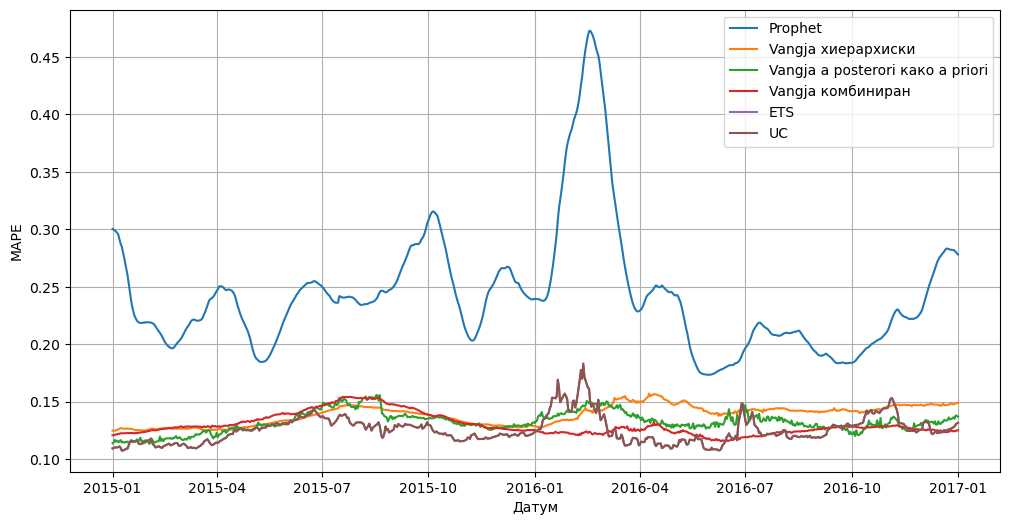

In [29]:
paths = [
    # arima_path,
    prophet_path,
    # timeseers_path / "model_4",
    hierarchical_path / "model_6",
    vangja_path / "model_5",
    vangja_delta_path / "model_3",
    es_path,
    uc_path,
]
labels = [
    # "ARIMA",
    "Prophet",
    # "Timeseers",
    "Vangja хиерархиски",
    "Vangja a posterori како a priori",
    "Vangja комбиниран",
    "ETS",
    "UC",
]

plt.figure(figsize=(12, 6))

for idx, (path, label) in enumerate(zip(paths, labels)):
    dates = []
    mapes = []
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
        csv_path = (
            path / f"prophet_{point_str}_multiplicative_lt0_w.csv"
            if idx == 0
            else path / f"{point_str}.csv"
        )

        if not csv_path.is_file():
            continue

        dates.append(point)
        df = pd.read_csv(csv_path, index_col=0)
        df = df[df.index != "^GSPC"]
        mapes.append(df["mape"].mean())

    print(label, len(dates))
    plt.plot(dates, mapes, label=f"{label}")

plt.grid()
plt.xlabel("Датум")
plt.ylabel("MAPE")
plt.legend()

In [27]:
df

,mse,rmse,mae,mape
A,0.104708,0.323586,0.289369,0.220664
AAL,0.004429,0.066549,0.054207,0.055830
AAP,0.099166,0.314907,0.270128,0.465623
AAPL,0.109179,0.330423,0.302229,0.225070
ABBV,0.096107,0.310011,0.226687,0.164102
...,...,...,...,...
YUM,0.030933,0.175878,0.146065,0.123212
ZBH,0.015590,0.124860,0.117934,0.129127
ZBRA,0.033031,0.181745,0.154761,0.129311
ZION,0.005609,0.074893,0.057139,0.054573
